In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/Alzheimer MRI Classification/archive.zip'


Streaming output truncated to the last 5000 lines.
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem207.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem208.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem209.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem21.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem210.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem211.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem212.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem213.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem214.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem215.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem216.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem217.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem218.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/m

# Import Necessary Libraries

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix,cohen_kappa_score
import seaborn as sn
from tensorflow.keras import backend as K
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation, Conv2D, MaxPooling2D, LeakyReLU,BatchNormalization
from tensorflow.keras.callbacks import TensorBoard
import pickle
from PIL import Image
import time
import os
from PIL import Image
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split

# from sklearn.model_selection import KFold

start = time.time()

# Experiment 
* Optimizer = Adam 
* learning rate = 0.0001
* Data Augmentation Techniques = image zooming, brightness change
* batch size = 20 while training
* Architecture = VGG16
* one hidden layer with 1024 units as classification layer followed by dropout of 0.25
* activation function = reLU
* SMOTE = None

# Set hyperparameters

In [ ]:
## variables for the fiddling with (99% val_acc with .0339 val_loss)

dim = (176,208)               # input image dimensions                                              (176,208)
test_split_percent = .1       # % of total data for testing                                         .1
validation_split_percent = .2 # % of total data for validation                                      .2
zoom = [.99,1.01]             # zoom range (for a fixed zoom put the same value in both parameters)[.99,1.01]
bright_range = [.8,1.2]       # brightness range                                                    [.8,1.2] 
layers_unlocked = True        # unlock the imported pre-training layers?                            False  
lr = 0.0001                   # learning rate for optimizer                                         0.0001
batch = 20                    # batch size for model fitting                                        20
eps = 10                      # number of epochs to run                                             50
                 # momentum of SGD                                                     .9

save_model_name = "val%2d_epochs%d"%(validation_split_percent*100,eps)   # automatically generate a model save name
print(save_model_name)


val20_epochs10


In [ ]:
# This section uses the ImageDataGenerator and flow_from_directory functions to sort the images by label
#actual dimensions 176x208x1

# introduced zoom, blew up the image of the brain itself, and brightness range to adjust for different brightness
train_dr = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                           fill_mode='constant',
                                                           cval=0,
                                                           brightness_range=bright_range,
                                                           zoom_range=zoom,
                                                           data_format='channels_last',
                                                           zca_whitening=False)

train_data_gen = train_dr.flow_from_directory(directory="/content/Alzheimer_s Dataset/train/",
                                              target_size=dim,
                                              batch_size=5000)

# Change to zoom = [1,1] to use normal test data
test_dr = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,fill_mode='constant',
                                                          cval=0,zoom_range=[1,1],
                                                          data_format='channels_last') 

test_data_gen = test_dr.flow_from_directory(directory="/content/Alzheimer_s Dataset/test/",
                                            target_size=dim,
                                            batch_size=5000,
                                           shuffle = False) # test data should not be shuffled to keep labels

Found 5121 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


In [ ]:
# This section assigns the images to numpy arrays for the data and labels
# EX: train_data = numpy array of image data, train_labels = numpy array of labels 

train_data,train_labels =  train_data_gen.next()
test_data,test_labels = test_data_gen.next()

# val_data,val_labels = val_data_gen.next()

In [ ]:
# cocatenate arrays, combining all data

total_data = np.concatenate((train_data,test_data))
total_labels = np.concatenate((train_labels,test_labels))
print(total_data.shape)
print(total_labels.shape)

(6279, 176, 208, 3)
(6279, 4)


In [ ]:
# train test split

initial_split = test_split_percent+validation_split_percent
test_val_split = test_split_percent/initial_split

# split into training and (test + validation)
train_data, test_val_data, train_labels, test_val_labels = train_test_split(total_data,total_labels,
                                                                            test_size=initial_split)

# split (test + validation) into test and validation sets
test_data, val_data, test_labels, val_labels = train_test_split(test_val_data,test_val_labels,
                                                                test_size=test_val_split)

print('train: ',train_data.shape)
print('validation',val_data.shape)
print('test',test_data.shape)

train:  (4395, 176, 208, 3)
validation (628, 176, 208, 3)
test (1256, 176, 208, 3)


# Sanity Checks

In [ ]:
# Check array dimensions
print(train_data.shape)
print(train_labels.shape)
print(val_data.shape)
print(val_labels.shape)
print(test_data.shape)
print(test_labels.shape)

(4395, 176, 208, 3)
(4395, 4)
(628, 176, 208, 3)
(628, 4)
(1256, 176, 208, 3)
(1256, 4)


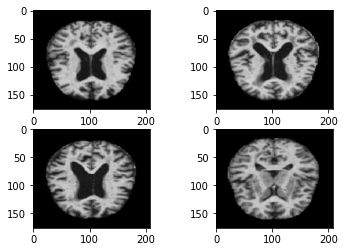

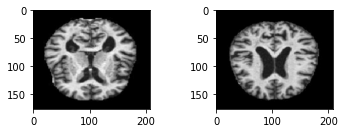

In [ ]:
# check some images
plt.subplot(221)
plt.imshow(train_data[1,:,:,:])
plt.subplot(222)
plt.imshow(train_data[2,:,:,:])
plt.subplot(223)
plt.imshow(val_data[3,:,:,:])
plt.subplot(224)
plt.imshow(val_data[4,:,:,:])
plt.show()
plt.subplot(221)
plt.imshow(test_data[5,:,:,:])
plt.subplot(222)
plt.imshow(test_data[154,:,:,:])

In [ ]:
# preprocess the images in the same manner as those trained on original model
#train_data = preprocess_input(train_data)
#val_data = preprocess_input(val_data)
#test_data = preprocess_input(test_data)
print(np.amax(train_data))
print(np.amin(train_data))
print(np.amax(val_data))
print(np.amin(val_data))

1.0
0.0
1.0
0.0


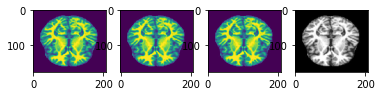

In [ ]:
# check image channels
plt.subplot(141)
plt.imshow(train_data[3,:,:,0])
plt.subplot(142)
plt.imshow(train_data[3,:,:,1])
plt.subplot(143)
plt.imshow(train_data[3,:,:,2])
plt.subplot(144)
plt.imshow(train_data[3,:,:,:])

# Create Model
or to load a model, skip down to "Load Model", then you can either continue training that model by skipping the next cell, or jump to "Evaluate Model"

In [ ]:
# import pre-trained VGG16 model

vg_model = tf.keras.applications.vgg16.VGG16(include_top=False,input_shape=(dim[0],dim[1],3), pooling = 'max') #added pooling

## IF YOU LOADED A MODEL AND WANT TO CONTINUE TRAINING, comment above, uncomment below
# vg_model = vg_model(include_top=False,input_shape=(dim[0],dim[1],3), pooling = 'max') #added pooling

58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
for i, layer in enumerate(vg_model.layers):
    print(i, layer.name)

0 input_1
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool
19 global_max_pooling2d


In [ ]:
## CHANGE MODEL STRUCTURE ##

# retrain some of the convolutional layers deep in the model, but not the fully connected layers at the end
vg_model.get_layer('block1_conv1').trainable = layers_unlocked
vg_model.get_layer('block1_conv2').trainable = layers_unlocked
vg_model.get_layer('block2_conv1').trainable = layers_unlocked
vg_model.get_layer('block2_conv2').trainable = layers_unlocked
vg_model.get_layer('block3_conv1').trainable = layers_unlocked
vg_model.get_layer('block3_conv2').trainable = layers_unlocked
vg_model.get_layer('block3_conv3').trainable = layers_unlocked
vg_model.get_layer('block4_conv1').trainable = layers_unlocked
vg_model.get_layer('block4_conv2').trainable = layers_unlocked
vg_model.get_layer('block4_conv3').trainable = layers_unlocked

## always leave last layer trainable ##
# vg_model.get_layer('block5_conv1').trainable = False
# vg_model.get_layer('block5_conv2').trainable = False
# vg_model.get_layer('block5_conv3').trainable = False

## Add new trainable FC layers ##
flat = Flatten()(vg_model.output)
fc1 = Dense(1024,activation='relu', kernel_initializer='he_uniform')(flat) # put in kernel initializer he-uniform
dp1 = Dropout(0.25)(fc1)                                                   # changed dropout here from .5
output = Dense(4,activation='softmax')(dp1)                                # changed to sigmoid from softmax
vg_model = Model(inputs=vg_model.inputs, outputs=output)

vg_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 176, 208, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 176, 208, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 176, 208, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 88, 104, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 88, 104, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 88, 104, 128)      147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 44, 52, 128)       0     

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc')
]

In [ ]:
# compile the model
#changed from tf.keras.optimizers.Adam(learning_rate=.0001) to SGD+nest.+momentum
opt = tf.keras.optimizers.Adam(learning_rate=lr) 

vg_model.compile(optimizer=opt, loss=tf.keras.losses.categorical_crossentropy, metrics=METRICS)

# Train the Model



In [ ]:
# train the model
model_history = vg_model.fit(train_data,train_labels,validation_data=(val_data,val_labels), epochs=eps,batch_size=batch, shuffle=True) #changed batch size from 15

scores = vg_model.evaluate(train_data, train_labels)

print("Accuracy: %.2f%%" %(scores[1]*100))

Epoch 1/10
220/220 [==============================] - 155s 536ms/step - loss: 1.0830 - accuracy: 0.7527 - precision: 0.5088 - recall: 0.3088 - auc: 0.7773 - val_loss: 1.0369 - val_accuracy: 0.7723 - val_precision: 0.5562 - val_recall: 0.4411 - val_auc: 0.8078
Epoch 2/10
220/220 [==============================] - 110s 500ms/step - loss: 0.9639 - accuracy: 0.7931 - precision: 0.6407 - recall: 0.3927 - auc: 0.8269 - val_loss: 0.9521 - val_accuracy: 0.7914 - val_precision: 0.8377 - val_recall: 0.2054 - val_auc: 0.8350
Epoch 3/10
220/220 [==============================] - 110s 501ms/step - loss: 0.8883 - accuracy: 0.8096 - precision: 0.6760 - recall: 0.4576 - auc: 0.8553 - val_loss: 0.8425 - val_accuracy: 0.8133 - val_precision: 0.6992 - val_recall: 0.4443 - val_auc: 0.8643
Epoch 4/10
220/220 [==============================] - 110s 501ms/step - loss: 0.8220 - accuracy: 0.8259 - precision: 0.7038 - recall: 0.5245 - auc: 0.8787 - val_loss: 0.8898 - val_accuracy: 0.7954 - val_precision: 0.5976

# Plots and Values

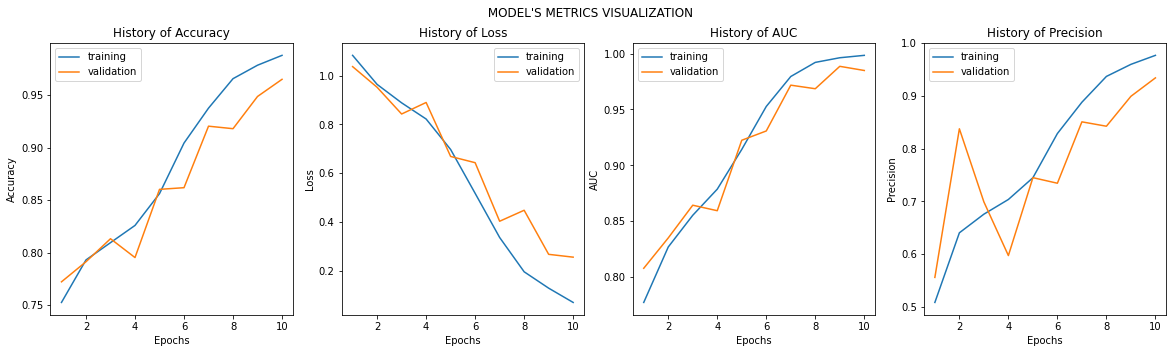

In [ ]:
#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision):
    
    fig, (ax1, ax2,ax3,ax4) = plt.subplots(1,4, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    plt.show()
    

Train_Val_Plot(model_history.history['accuracy'],model_history.history['val_accuracy'],
               model_history.history['loss'],model_history.history['val_loss'],
               model_history.history['auc'],model_history.history['val_auc'],
               model_history.history['precision'],model_history.history['val_precision']
             
              )

# Performance Evaluation
Come here after loading model

In [ ]:
### PERFORMANCE EVALUATION ##
train_scores = vg_model.evaluate(train_data, train_labels)
val_scores = vg_model.evaluate(val_data,val_labels)
test_scores = vg_model.evaluate(test_data, test_labels)

print('Train Accuracy: %.2f%%'%(train_scores[1]*100))
print('Validation Accuracy: %.2f%%'%(val_scores[1]*100))
print('Test Accuracy: %.2f%%'%(test_scores[1]*100))

40/40 [==============================] - 7s 187ms/step - loss: 0.2299 - accuracy: 0.9670 - precision: 0.9381 - recall: 0.9291 - auc: 0.9883
Train Accuracy: 99.57%
Validation Accuracy: 96.50%
Test Accuracy: 96.70%


In [ ]:
#test_scores = vg_model.evaluate(test_data, test_labels)
print("Accuracy = ", np.round(test_scores[1],2))
print("Precision = ", np.round(test_scores[2],2))
print("Recall = ", np.round(test_scores[3],2))
print("AUC = ", np.round(test_scores[4],2))

Accuracy =  0.97
Precision =  0.94
Recall =  0.93
AUC =  0.99


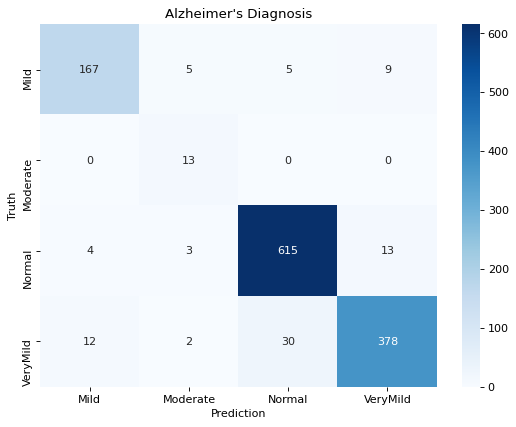

In [ ]:
## CONFUSION MATRIX ##

predic = vg_model.predict(test_data)

predic = np.argmax(predic, axis=1)
labels = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(labels, predic)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax = sn.heatmap(conf_arr, cmap='Blues', annot=True, fmt='d', xticklabels= ['Mild', 'Moderate', 'Normal', 'VeryMild'],
                yticklabels=['Mild', 'Moderate', 'Normal', 'VeryMild'])
plt.title('Alzheimer\'s Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
# plt.subplots(figsize=(9, 6))
plt.show(ax)


In [ ]:
print(classification_report(labels,predic))

              precision    recall  f1-score   support

           0       0.91      0.90      0.91       186
           1       0.57      1.00      0.72        13
           2       0.95      0.97      0.96       635
           3       0.94      0.90      0.92       422

    accuracy                           0.93      1256
   macro avg       0.84      0.94      0.88      1256
weighted avg       0.94      0.93      0.93      1256



# Saving the Model

In [ ]:
vg_model.save('/content/drive/MyDrive/Alzheimer MRI Classification/saved model/my_model.h5')

In [ ]:
model=load_model('/content/drive/MyDrive/Alzheimer MRI Classification/saved model/my_model.h5')

In [ ]:
train_pred = model.predict(train_data)
train_pred = np.argmax(train_pred, axis=1)
train_labels = np.argmax(train_labels, axis=1)
print("Train Cohen Kappa Score",np.round(cohen_kappa_score(train_labels, train_pred),2))

test_pred = model.predict(test_data)
test_pred = np.argmax(test_pred, axis=1)
test_labels = np.argmax(test_labels, axis=1)
print("Test Cohen kappa Score",np.round(cohen_kappa_score(test_labels, test_pred),2))

Train Cohen Kappa Score 0.94
Test Cohen kappa Score 0.97


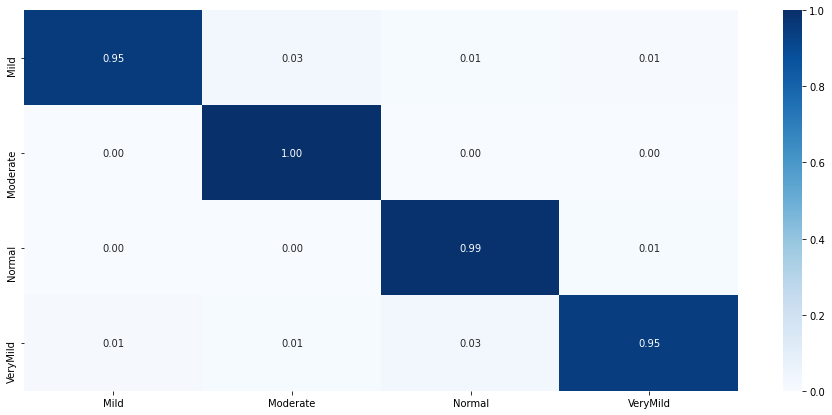

In [ ]:

labels = ['Mild', 'Moderate', 'Normal', 'VeryMild']
test_pred = model.predict(test_data)
test_pred = np.argmax(test_pred, axis=1)
test_labels = np.argmax(test_labels, axis=1)
cnf_matrix = confusion_matrix(test_labels, test_pred)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels, columns=labels)
plt.figure(figsize=(16, 7))
sn.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues")
plt.show()

# Application Phase

In [ ]:
model = load_model('/content/drive/MyDrive/Alzheimer MRI Classification/saved model/my_model.h5')
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 176, 208, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 176, 208, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 176, 208, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 88, 104, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 88, 104, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 88, 104, 128)      147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 44, 52, 128)       0     

# GradCam

In [ ]:
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import cv2

class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")


    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output, self.model.output])

        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            
            loss = predictions[:, tf.argmax(predictions[0])]
    
        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)

        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        # return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
                        colormap=cv2.COLORMAP_VIRIDIS):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)

## Prediction for Mild Demented

In [ ]:
image = cv2.imread('/content/Alzheimer_s Dataset/test/MildDemented/26 (19).jpg')
image = cv2.resize(image, (208,176))
#image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
image = image.astype('float32') / 255
image = np.expand_dims(image, axis=0)

preds = model.predict(image) 
i = np.argmax(preds[0])
print(i)
if i==0:
  print("Mild Demented")
elif i==1:
  print('Moderate Demented')
elif i==2:
  print("Non Demented")
elif i==3:
  print("Very Mild Demented")

0
Mild Demented


In [ ]:
for idx in range(len(model.layers)):
  print(model.get_layer(index = idx).name)

# we picked `block5c_project_con` layer 

input_4
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool
global_max_pooling2d_3
flatten_5
dense_10
dropout_5
dense_11


In [ ]:
icam = GradCAM(model, i,'block3_conv3') 
heatmap = icam.compute_heatmap(image)
heatmap = cv2.resize(heatmap, (176, 208))

image = cv2.imread('/content/Alzheimer_s Dataset/test/MildDemented/26 (19).jpg')
image = cv2.resize(image, (176, 208))
print(heatmap.shape, image.shape)

(heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)

(208, 176) (208, 176, 3)


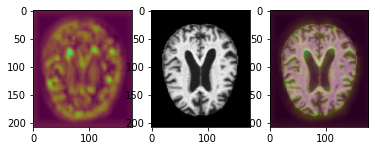

In [ ]:
fig, ax = plt.subplots(1, 3)

ax[0].imshow(heatmap)
ax[1].imshow(image)
ax[2].imshow(output)

## Prediction for Moderate Demented

In [ ]:
image = cv2.imread('/content/Alzheimer_s Dataset/test/ModerateDemented/27 (2).jpg')
image = cv2.resize(image, (208,176))
#image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
image = image.astype('float32') / 255
image = np.expand_dims(image, axis=0)

preds = model.predict(image) 
i = np.argmax(preds[0])
print(i)
if i==0:
  print("Mild Demented")
elif i==1:
  print('Moderate Demented')
elif i==2:
  print("Non Demented")
elif i==3:
  print("Very Mild Demented")

1
Moderate Demented


In [ ]:
for idx in range(len(model.layers)):
  print(model.get_layer(index = idx).name)

# we picked `block5c_project_con` layer 

input_4
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool
global_max_pooling2d_3
flatten_5
dense_10
dropout_5
dense_11


In [ ]:
icam = GradCAM(model, i,'block4_conv3') 
heatmap = icam.compute_heatmap(image)
heatmap = cv2.resize(heatmap, (176, 208))

image = cv2.imread('/content/Alzheimer_s Dataset/test/ModerateDemented/27 (2).jpg')
image = cv2.resize(image, (176, 208))
print(heatmap.shape, image.shape)

(heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)

(208, 176) (208, 176, 3)


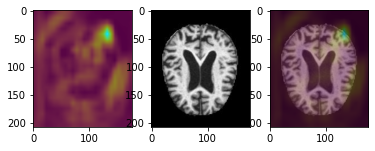

In [ ]:
fig, ax = plt.subplots(1, 3)

ax[0].imshow(heatmap)
ax[1].imshow(image)
ax[2].imshow(output)

## Prediction for Non Demented

In [ ]:
image = cv2.imread('/content/Alzheimer_s Dataset/test/NonDemented/26 (63).jpg')
image = cv2.resize(image, (208,176))
#image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
image = image.astype('float32') / 255
image = np.expand_dims(image, axis=0)

preds = model.predict(image) 
i = np.argmax(preds[0])
print(i)
if i==0:
  print("Mild Demented")
elif i==1:
  print('Moderate Demented')
elif i==2:
  print("Non Demented")
elif i==3:
  print("Very Mild Demented")

2
Non Demented


In [ ]:
for idx in range(len(model.layers)):
  print(model.get_layer(index = idx).name)

# we picked `block5c_project_con` layer 

input_4
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool
global_max_pooling2d_3
flatten_5
dense_10
dropout_5
dense_11


In [ ]:
icam = GradCAM(model, i,'block4_conv3') 
heatmap = icam.compute_heatmap(image)
heatmap = cv2.resize(heatmap, (176, 208))

image = cv2.imread('/content/Alzheimer_s Dataset/test/NonDemented/26 (63).jpg')
image = cv2.resize(image, (176, 208))
print(heatmap.shape, image.shape)

(heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)

(208, 176) (208, 176, 3)


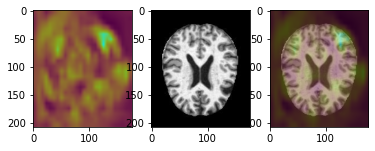

In [ ]:
fig, ax = plt.subplots(1, 3)

ax[0].imshow(heatmap)
ax[1].imshow(image)
ax[2].imshow(output)

## Prediction for Very Mild Demented

In [ ]:
image = cv2.imread('/content/Alzheimer_s Dataset/test/VeryMildDemented/26 (49).jpg')
image = cv2.resize(image, (208,176))
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
image = image.astype('float32') / 255
image = np.expand_dims(image, axis=0)

preds = model.predict(image) 
i = np.argmax(preds[0])
print(i)
if i==0:
  print("Mild Demented")
elif i==1:
  print('Moderate Demented')
elif i==2:
  print("Non Demented")
elif i==3:
  print("Very Mild Demented")

3
Very Mild Demented


In [ ]:
for idx in range(len(model.layers)):
  print(model.get_layer(index = idx).name)

# we picked `block5c_project_con` layer 

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool
global_max_pooling2d
flatten
dense
dropout
dense_1


In [ ]:
icam = GradCAM(model, i,'block4_conv3') 
heatmap = icam.compute_heatmap(image)
heatmap = cv2.resize(heatmap, (176, 208))

image = cv2.imread('/content/Alzheimer_s Dataset/test/VeryMildDemented/26 (49).jpg')
image = cv2.resize(image, (176, 208))
print(heatmap.shape, image.shape)

(heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)

(208, 176) (208, 176, 3)


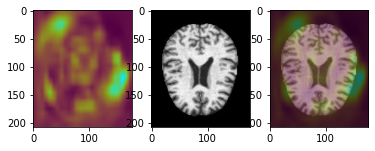

In [ ]:
fig, ax = plt.subplots(1, 3)

ax[0].imshow(heatmap)
ax[1].imshow(image)
ax[2].imshow(output)